In [1]:
%load_ext autoreload
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from faces_clustering import VideoClustering

from mtcnn_torch import MTCNN_Torch
from sphere_mtcnn import SphereMTCNN_Torch
from faces_viewport import MTCNN_tf, ViewportsFaceDetector

Using TensorFlow backend.


In [2]:
mtcnn_torch = MTCNN_Torch()
mtcnn_tf = MTCNN_tf()
viewports_torch = ViewportsFaceDetector(torch = True, width = 200, rows = 3, cols = 6, nms_th=0.25)
viewports_tf = ViewportsFaceDetector(torch = False, width = 200, rows = 3, cols = 6, nms_th=0.25)

In [3]:
video_clustering = VideoClustering('senet50', viewports_torch, 'agglomerative', verbose=0)

### Clustering Video Faces Using Its Frames

In [4]:
res = video_clustering.cluster("D:/Movies/360Video/omelete.mp4", fps=1)

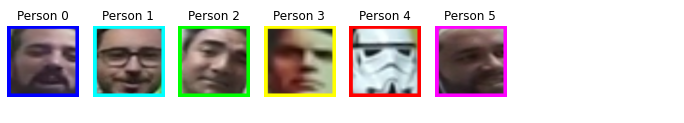

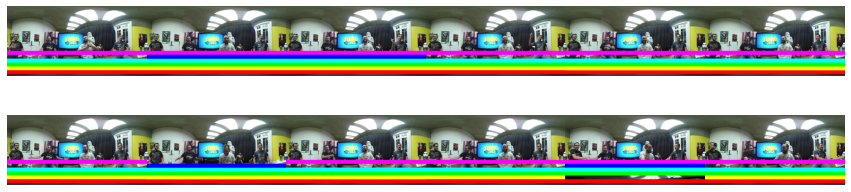

In [7]:
video_clustering.display_timeline(lines = True, limit = 12)

### Positions of Actors

In [50]:
#adjusting dataframe

columns_subtitles = ['frames','urls', 'bounds', video_clustering.cluster_column]
actors_pos =  res[columns_subtitles].copy()
actors_pos.columns = ['frames','urls', 'bounds', 'actors_id']
actors_pos.sort_values(by=['frames'], inplace = True)
actors_pos.reset_index(drop=True, inplace = True)

In [51]:
#obtaining the center position of the bounding boxes

actors_pos['center_face_pos'] = actors_pos.bounds.apply(lambda x: np.array(x).mean(axis = 0))
actors_pos.head()

,frames,urls,bounds,actors_id,center_face_pos
0,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(96, 393), (123, 396), (149, 399), (149, 430)...",1,"[122.625, 429.5]"
1,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1535, 397), (1561, 396), (1589, 395), (1589,...",2,"[1561.75, 429.875]"
2,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(542, 417), (569, 415), (596, 414), (596, 450...",0,"[569.0, 451.0]"
3,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1043, 411), (1071, 413), (1100, 416), (1100,...",5,"[1071.375, 447.875]"
4,30,D:/Movies/360Video/omelete\frame_30.jpg,"[(1820, 385), (1836, 384), (1855, 383), (1855,...",3,"[1837.125, 406.375]"
